In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('/workspaces/Deep-learning-for-condominium-price-prediction-using-heterogeneous-analysis/input_model/tabular_data/final_condo_list.csv',encoding='cp874')

print(f"ขนาดข้อมูล: {df.shape}")
df.head()

2025-12-03 11:20:34.553901: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 11:20:35.510459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 11:20:42.568607: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


ขนาดข้อมูล: (16515, 32)


,name,district,lat,long,sale_price,asking_price,asking_price_change_quater,asking_price_change_year,gross_rental_yield,rental_price_change_year,...,has_gym,has_garden_bbq,has_playground,has_shop_on_premise,has_restaurant_on_premise,has_wifi,city_train_distance,express_way_distance,close_city_train,close_express_way
0,The President Sukhumvit,Phra Khanong,13.584769,100.609088,4190000.0,114054.0,0.0,-1.8,4.5,-4.1,...,1.0,1.0,0.0,0.0,0.0,1.0,200.0,1300.0,1.0,0.0
1,The President Sukhumvit,Phra Khanong,13.584769,100.609088,4400000.0,114054.0,0.0,-1.8,4.5,-4.1,...,1.0,1.0,0.0,0.0,0.0,1.0,200.0,1300.0,1.0,0.0
2,The President Sukhumvit,Phra Khanong,13.584769,100.609088,4200000.0,114054.0,0.0,-1.8,4.5,-4.1,...,1.0,1.0,0.0,0.0,0.0,1.0,200.0,1300.0,1.0,0.0
3,The President Sukhumvit,Phra Khanong,13.584769,100.609088,4100000.0,114054.0,0.0,-1.8,4.5,-4.1,...,1.0,1.0,0.0,0.0,0.0,1.0,200.0,1300.0,1.0,0.0
4,The President Sukhumvit,Phra Khanong,13.584769,100.609088,4250000.0,114054.0,0.0,-1.8,4.5,-4.1,...,1.0,1.0,0.0,0.0,0.0,1.0,200.0,1300.0,1.0,0.0


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

# 1. เตรียมข้อมูล (ตัด asking_price ออก)
# สมมติว่า df_filtered คือข้อมูลที่ตัด Outlier แล้วจากขั้นตอนก่อนหน้า
# ถ้าไม่มีให้เริ่มจาก df_clean แล้วตัด Outlier ใหม่อีกรอบได้ครับ

# --- Drop asking_price ---
# เราจะตัด 'asking_price' และคอลัมน์ที่เกี่ยวข้องกับราคาขายต่อ ตร.ม. ออก
drop_cols = ['sale_price', 'asking_price', 'asking_price_change_quater', 'asking_price_change_year']

# เช็คว่ามีคอลัมน์ไหนให้ลบบ้าง (กัน error)
existing_drop_cols = [c for c in drop_cols if c in df_filtered.columns]

X_real = df_filtered.drop(columns=existing_drop_cols)
y_real = df_filtered['sale_price']

# 2. เตรียม Preprocessor ใหม่ (เพราะจำนวนคอลัมน์เปลี่ยนไป)
categorical_cols = ['district']
numerical_cols = [c for c in X_real.columns if c not in categorical_cols]

preprocessor_real = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# 3. แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

# Fit Preprocessor
X_train_processed = preprocessor_real.fit_transform(X_train)
X_test_processed = preprocessor_real.transform(X_test)

# แปลง y เป็น Log เหมือนเดิม
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"จำนวน Features ที่ใช้จริงรอบนี้: {X_train_processed.shape[1]}")

# 4. สร้างและเทรน XGBoost (แบบไม่มี asking_price)
model_xgb_real = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

print("กำลังเทรนโมเดล (แบบยากขึ้นเพราะไม่มีราคาตั้งต้น)...")
model_xgb_real.fit(
    X_train_processed, y_train_log,
    eval_set=[(X_test_processed, y_test_log)],
    verbose=100
)

# 5. วัดผล
y_pred_log = model_xgb_real.predict(X_test_processed)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*40)
print(f"ผลลัพธ์ (เมื่อไม่มี Asking Price):")
print(f"MAE: {mae:,.2f} บาท")
print(f"R2 Score: {r2:.4f}")
print("="*40)

จำนวน Features ที่ใช้จริงรอบนี้: 72
กำลังเทรนโมเดล (แบบยากขึ้นเพราะไม่มีราคาตั้งต้น)...
[0]	validation_0-rmse:0.92215
[100]	validation_0-rmse:0.16357
[200]	validation_0-rmse:0.15482
[300]	validation_0-rmse:0.15145
[400]	validation_0-rmse:0.14966
[500]	validation_0-rmse:0.14901
[600]	validation_0-rmse:0.14806
[700]	validation_0-rmse:0.14752
[800]	validation_0-rmse:0.14704
[900]	validation_0-rmse:0.14687
[975]	validation_0-rmse:0.14688

ผลลัพธ์ (เมื่อไม่มี Asking Price):
MAE: 1,162,069.77 บาท
R2 Score: 0.9490


/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3594 (\N{THAI CHARACTER CHO CHANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3655 (\N{THAI CHARACTER MAITAIKHU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/1719941753.py:40: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) D

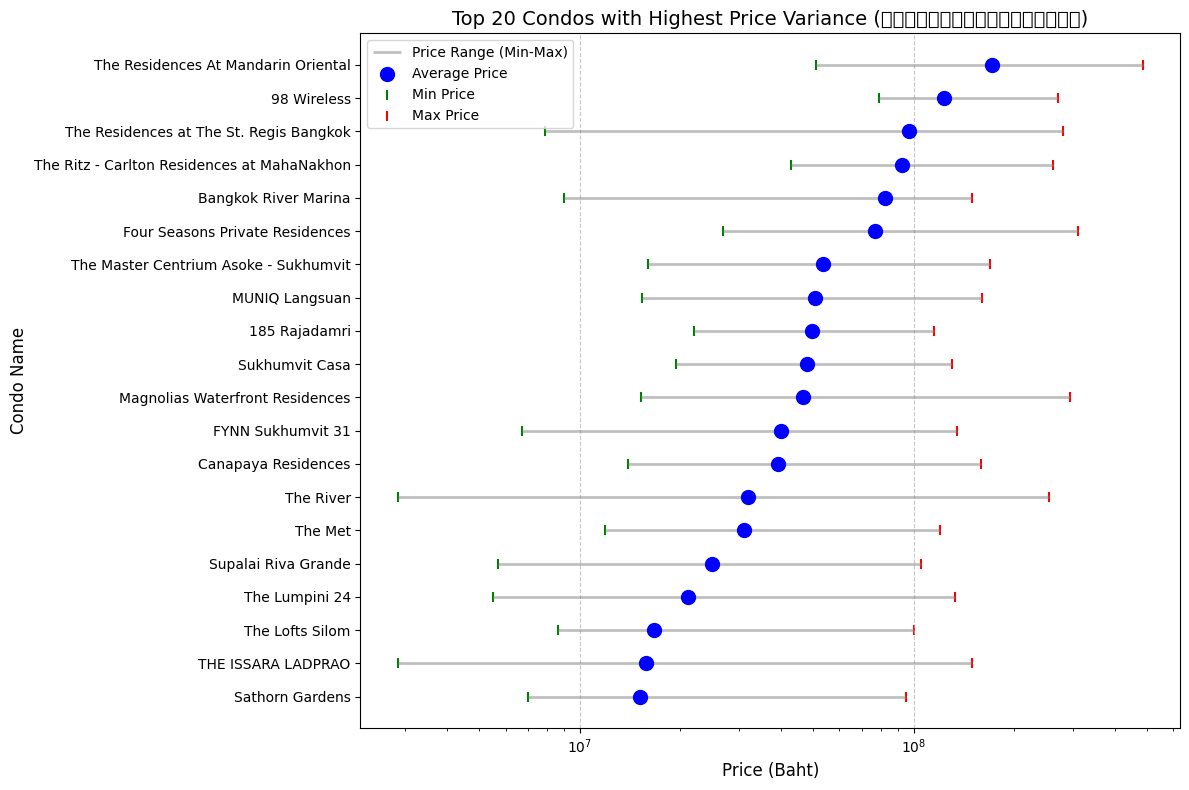

ตารางข้อมูล 20 อันดับที่มีความแกว่งของราคาสูงสุด:
                                                    min          max  \
name                                                                   
The Residences At Mandarin Oriental          51000000.0  485966287.0   
Four Seasons Private Residences              26900000.0  310000000.0   
Magnolias Waterfront Residences              15300000.0  295000000.0   
The Residences at The St. Regis Bangkok       7900000.0  280000000.0   
The River                                     2850000.0  254984000.0   
The Ritz - Carlton Residences at MahaNakhon  43000000.0  262000000.0   
98 Wireless                                  79000000.0  270000000.0   
The Master Centrium Asoke - Sukhumvit        16000000.0  170000000.0   
THE ISSARA LADPRAO                            2850000.0  150000000.0   
Canapaya Residences                          13990000.0  159000000.0   
MUNIQ Langsuan                               15400000.0  160000000.0   
Bangkok River 

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. โหลดข้อมูล (ต้องใช้ตัวที่มี column 'name' นะครับ)
# ถ้า df เดิมลบ name ไปแล้ว ให้โหลดใหม่
df_check = df

# 2. คำนวณ สูงสุด-ต่ำสุด-เฉลี่ย ตามชื่อคอนโด
price_stats = df_check.groupby('name')['sale_price'].agg(['min', 'max', 'mean', 'count'])

# 3. หา "ส่วนต่างราคา" (Spread) เพื่อดูว่าที่ไหนราคาโดดผิดปกติที่สุด
price_stats['spread'] = price_stats['max'] - price_stats['min']

# 4. คัดเลือก Top 20 คอนโดที่มีส่วนต่างราคาสูงที่สุด (ตัวปัญหา)
top_variance = price_stats.sort_values(by='spread', ascending=False).head(20)

# เตรียมข้อมูลสำหรับวาดกราฟ
top_variance = top_variance.sort_values(by='mean', ascending=True) # เรียงตามราคาเฉลี่ยให้ดูกราฟง่าย

# 5. วาดกราฟ High-Low-Average
plt.figure(figsize=(12, 8))

# วาดเส้นช่วงราคา (Min ถึง Max)
plt.hlines(y=top_variance.index, xmin=top_variance['min'], xmax=top_variance['max'], color='gray', alpha=0.5, linewidth=2, label='Price Range (Min-Max)')

# วาดจุดราคาเฉลี่ย (Mean)
plt.scatter(top_variance['mean'], top_variance.index, color='blue', s=100, label='Average Price', zorder=3)

# วาดจุดต่ำสุด (Min) และสูงสุด (Max) เพื่อให้เห็นชัดๆ
plt.scatter(top_variance['min'], top_variance.index, color='green', s=50, marker='|', label='Min Price')
plt.scatter(top_variance['max'], top_variance.index, color='red', s=50, marker='|', label='Max Price')

plt.title('Top 20 Condos with Highest Price Variance (เช็คข้อมูลผิดปกติ)', fontsize=14)
plt.xlabel('Price (Baht)', fontsize=12)
plt.ylabel('Condo Name', fontsize=12)
plt.xscale('log') # แนะนำ: ใช้สเกล Log เพราะราคาอาจจะต่างกันหลักสิบล้าน จะได้เห็นช่วงชัดขึ้น
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# 6. แสดงข้อมูลเป็นตารางด้วย (เผื่อก๊อปไปเช็ค)
print("ตารางข้อมูล 20 อันดับที่มีความแกว่งของราคาสูงสุด:")
print(top_variance[['min', 'max', 'mean', 'count', 'spread']].sort_values(by='spread', ascending=False))

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. โหลดข้อมูล (เปลี่ยน path ตามเครื่องของคุณ)
df = df

# 2. ดูสถิติก่อนตัด
print(f"จำนวนข้อมูลทั้งหมด: {len(df)}")
print(f"ราคาสูงสุดเดิม: {df['sale_price'].max():,.0f} บาท")

# 3. กำหนดเพดานราคาที่จะตัด (Threshold)
# แนะนำ: ตัดที่ 50 ล้าน หรือ 80 ล้านบาท (ขึ้นอยู่กับกลุ่มเป้าหมาย)
price_limit = 50000000 
df_clean = df[df['sale_price'] <= price_limit]

# 4. ดูผลลัพธ์หลังตัด
print("-" * 30)
print(f"จำนวนข้อมูลที่เหลือ: {len(df_clean)}")
print(f"ตัดออกไปทั้งหมด: {len(df) - len(df_clean)} ห้อง")
print(f"ราคาสูงสุดใหม่: {df_clean['sale_price'].max():,.0f} บาท")

# 5. (ทางเลือก) ตัดห้องที่ราคาถูกผิดปกติด้วย (เช่น ต่ำกว่า 1 ล้านในทำเลเมือง)
df_clean = df_clean[df_clean['sale_price'] >= 1000000]

# --- นำ df_clean ไปใช้เทรนโมเดลต่อได้เลยครับ ---

จำนวนข้อมูลทั้งหมด: 16515
ราคาสูงสุดเดิม: 485,966,287 บาท
------------------------------
จำนวนข้อมูลที่เหลือ: 15972
ตัดออกไปทั้งหมด: 543 ห้อง
ราคาสูงสุดใหม่: 50,000,000 บาท


In [21]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# 1. เตรียมข้อมูล (ใช้ df_clean ที่ตัด Outlier แล้ว)
# ตัด column ที่เป็นเฉลย (asking_price) และ column ที่ไม่ใช้
drop_cols = ['sale_price', 'name', 'asking_price', 'asking_price_change_quater', 'asking_price_change_year', 'rental_price_change_year', 'gross_rental_yield']
existing_drop = [c for c in drop_cols if c in df_clean.columns]

X = df_clean.drop(columns=existing_drop)
y = df_clean['sale_price']

# 2. แบ่งข้อมูล Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. สร้าง Preprocessor (แปลงข้อมูล)
categorical_cols = ['district']
numerical_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit และแปลงข้อมูล
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 4. แปลงราคาเป้าหมายเป็น Log (เพื่อให้โมเดลเรียนรู้ง่ายขึ้น)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"จำนวนข้อมูลที่ใช้เทรน: {X_train_processed.shape[0]} แถว")
print(f"จำนวน Features: {X_train_processed.shape[1]}")

# 5. สร้างและเทรนโมเดล XGBoost
print("กำลังเทรนโมเดล... (รอสักครู่)")
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,        # เพิ่มจำนวนรอบการตัดสินใจ
    learning_rate=0.03,       # ลด Learning rate ให้เรียนละเอียดขึ้น
    max_depth=6,              # ความลึกของต้นไม้
    colsample_bytree=0.7,     # สุ่มใช้ feature 70%
    subsample=0.7,            # สุ่มใช้ข้อมูล 70%
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50  # หยุดถ้าไม่เก่งขึ้นใน 50 รอบ
)

model_xgb.fit(
    X_train_processed, y_train_log,
    eval_set=[(X_test_processed, y_test_log)],
    verbose=100
)

# 6. วัดผลลัพธ์ (Evaluation)
# ทำนายค่า (ได้ออกมาเป็น Log)
y_pred_log = model_xgb.predict(X_test_processed)
# แปลงกลับเป็นราคาบาท (Inverse Log)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n" + "="*40)
print(f"🎯 ผลลัพธ์หลังตัด Outlier และ Asking Price:")
print(f"MAE (ความคลาดเคลื่อนเฉลี่ย): {mae:,.2f} บาท")
print(f"MAPE (คลาดเคลื่อนเป็น %): {mape:.2f}%")
print(f"R2 Score (ความแม่นยำ): {r2:.4f}")
print("="*40)

จำนวนข้อมูลที่ใช้เทรน: 12721 แถว
จำนวน Features: 70
กำลังเทรนโมเดล... (รอสักครู่)
[0]	validation_0-rmse:0.86405
[100]	validation_0-rmse:0.21212
[200]	validation_0-rmse:0.18143
[300]	validation_0-rmse:0.17334
[400]	validation_0-rmse:0.16822
[500]	validation_0-rmse:0.16444
[600]	validation_0-rmse:0.16177
[700]	validation_0-rmse:0.15962
[800]	validation_0-rmse:0.15801
[900]	validation_0-rmse:0.15666
[1000]	validation_0-rmse:0.15550
[1100]	validation_0-rmse:0.15456
[1200]	validation_0-rmse:0.15376
[1300]	validation_0-rmse:0.15306
[1400]	validation_0-rmse:0.15243
[1500]	validation_0-rmse:0.15204
[1600]	validation_0-rmse:0.15173
[1700]	validation_0-rmse:0.15141
[1800]	validation_0-rmse:0.15113
[1900]	validation_0-rmse:0.15097
[1999]	validation_0-rmse:0.15070

🎯 ผลลัพธ์หลังตัด Outlier และ Asking Price:
MAE (ความคลาดเคลื่อนเฉลี่ย): 886,506.97 บาท
MAPE (คลาดเคลื่อนเป็น %): 10.51%
R2 Score (ความแม่นยำ): 0.9552


/tmp/ipykernel_10245/2383348728.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
/tmp/ipykernel_10245/2383348728.py:26: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/2383348728.py:26: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/2383348728.py:26: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/2383348728.py:26: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10245/2383348728.py:26: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from 

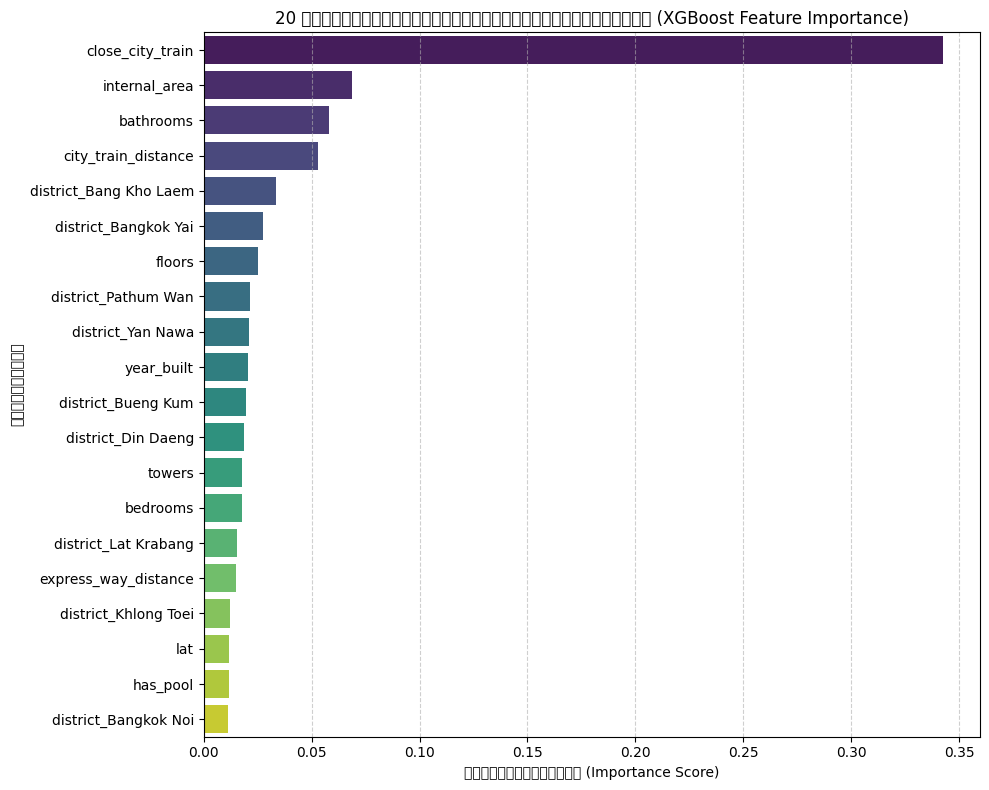

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ดึงชื่อ Feature ทั้งหมดออกมา
# (ต้องแกะชื่อจาก OneHotEncoder ที่อยู่ใน preprocessor)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(cat_features)

# ดึงค่าความสำคัญจากโมเดล
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': model_xgb.feature_importances_
})

# เรียงลำดับ 20 อันดับแรก
top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

# วาดกราฟ
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('20 ปัจจัยที่ส่งผลต่อราคาคอนโดมากที่สุด (XGBoost Feature Importance)')
plt.xlabel('ระดับความสำคัญ (Importance Score)')
plt.ylabel('ชื่อปัจจัย')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

กำลังเตรียมข้อมูล...
เริ่มการทดสอบ 5 อัลกอริทึม (อาจใช้เวลา 5-10 นาที)...
Training Ridge...
  --> Done! R2: -16.7833 | MAE: 2,934,039 | Used: 7.9s
Training RandomForest...
  --> Done! R2: 0.9473 | MAE: 937,451 | Used: 274.8s
Training XGBoost...
  --> Done! R2: 0.9562 | MAE: 883,462 | Used: 79.2s
Training LightGBM...


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.w

  --> Done! R2: 0.9519 | MAE: 923,933 | Used: 47.2s
Training GradientBoosting...
  --> Done! R2: 0.9484 | MAE: 959,327 | Used: 141.6s

🏆 สรุปผลการเปรียบเทียบโมเดล (เรียงตามความแม่นยำ)
           Model   MAE (Baht)  MAPE (%)    Best R2  Training Time (s)
         XGBoost 8.834620e+05 10.589064   0.956159          79.162188
        LightGBM 9.239326e+05 10.892628   0.951927          47.224434
    RandomForest 9.374510e+05 11.397560   0.947287         274.842692
GradientBoosting 9.593268e+05 11.261586   0.948375         141.594112
           Ridge 2.934039e+06 31.455426 -16.783326           7.927376


/tmp/ipykernel_46832/4114889171.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE (Baht)', y='Model', data=results_df, palette='viridis')


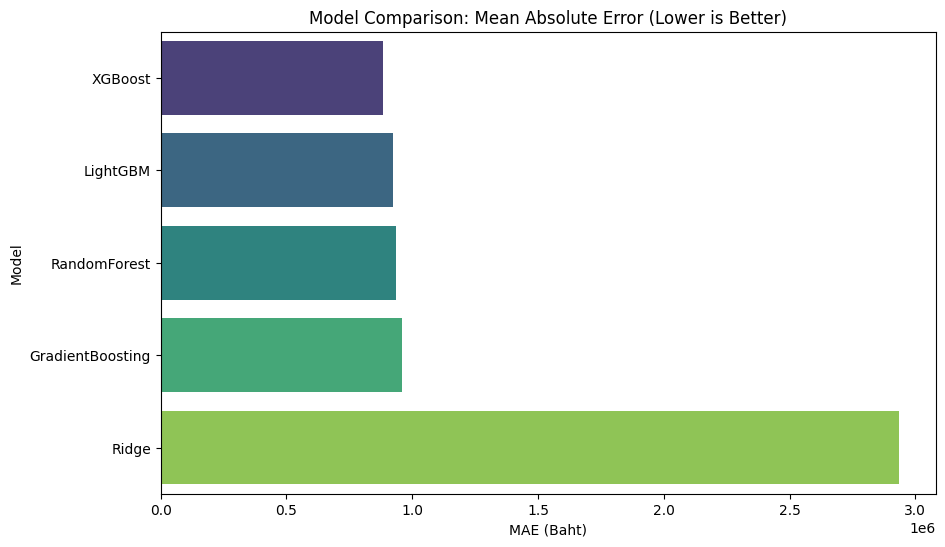


🥇 ผู้ชนะคือ: XGBoost
Best Parameters:
{'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 1000}


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# ==========================================
# 1. เตรียมข้อมูล (Data Preparation)
# ==========================================
print("กำลังเตรียมข้อมูล...")
df = df

# ตัด Outlier (ตามที่เราเคยตกลงกัน)
df_clean = df[(df['sale_price'] >= 1000000) & (df['sale_price'] <= 50000000)].copy()

# เลือก Features และ Target
drop_cols = ['sale_price', 'name', 'asking_price', 'asking_price_change_quater', 
             'asking_price_change_year', 'rental_price_change_year', 'gross_rental_yield']
existing_drop = [c for c in drop_cols if c in df_clean.columns]

X = df_clean.drop(columns=existing_drop)
y = np.log1p(df_clean['sale_price']) # แปลง Target เป็น Log

# แบ่ง Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
categorical_cols = ['district']
numerical_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# ==========================================
# 2. ตั้งค่า Grid Search (Model & Params)
# ==========================================

# กำหนดรายชื่อโมเดลและพารามิเตอร์ที่จะทดสอบ
model_params = {
    # 1. Ridge (Linear Baseline)
    'Ridge': {
        'model': Ridge(),
        'params': {
            'regressor__alpha': [0.1, 1.0, 10.0]
        }
    },
    
    # 2. Random Forest
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [10, 20, None],
            'regressor__min_samples_leaf': [1, 4]
        }
    },
    
    # 3. XGBoost
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'params': {
            'regressor__n_estimators': [500, 1000],
            'regressor__learning_rate': [0.01, 0.05],
            'regressor__max_depth': [5, 7]
        }
    },
    
    # 4. LightGBM (เร็วและแม่น)
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'regressor__n_estimators': [500, 1000],
            'regressor__learning_rate': [0.01, 0.05],
            'regressor__num_leaves': [31, 50]
        }
    },
    
    # 5. Gradient Boosting (Sklearn Classic)
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [200, 500],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [3, 5]
        }
    }
}

# ==========================================
# 3. เริ่มรัน GridSearchCV (Loop)
# ==========================================
results = []

print(f"เริ่มการทดสอบ 5 อัลกอริทึม (อาจใช้เวลา 5-10 นาที)...")
print("="*60)

for model_name, mp in model_params.items():
    start_time = time.time()
    
    # สร้าง Pipeline (Preprocessor + Model)
    # ใช้ชื่อ 'regressor' เพื่อให้อ้างอิงใน params ได้
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', mp['model'])])
    
    # สร้าง GridSearchCV
    # cv=3 คือแบ่ง Cross Validation 3 ส่วน (เพื่อความเร็ว)
    grid = GridSearchCV(clf, mp['params'], cv=3, scoring='r2', n_jobs=-1)
    
    # Train
    print(f"Training {model_name}...")
    grid.fit(X_train, y_train)
    
    # Evaluation
    best_model = grid.best_estimator_
    y_pred_log = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_log) # แปลงกลับเป็นบาท
    y_true = np.expm1(y_test)
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    duration = time.time() - start_time
    
    # เก็บผลลัพธ์
    results.append({
        'Model': model_name,
        'Best R2': r2,
        'MAE (Baht)': mae,
        'MAPE (%)': mape,
        'Best Params': grid.best_params_,
        'Training Time (s)': duration
    })
    
    print(f"  --> Done! R2: {r2:.4f} | MAE: {mae:,.0f} | Used: {duration:.1f}s")

# ==========================================
# 4. สรุปผล (Comparison Table)
# ==========================================
results_df = pd.DataFrame(results).sort_values(by='MAE (Baht)', ascending=True)

print("\n" + "="*60)
print("🏆 สรุปผลการเปรียบเทียบโมเดล (เรียงตามความแม่นยำ)")
print("="*60)
print(results_df[['Model', 'MAE (Baht)', 'MAPE (%)', 'Best R2', 'Training Time (s)']].to_string(index=False))

# วาดกราฟเปรียบเทียบ
plt.figure(figsize=(10, 6))
sns.barplot(x='MAE (Baht)', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: Mean Absolute Error (Lower is Better)')
plt.xlabel('MAE (Baht)')
plt.show()

# Print Best Parameters ของผู้ชนะ
winner = results_df.iloc[0]
print(f"\n🥇 ผู้ชนะคือ: {winner['Model']}")
print("Best Parameters:")
print(winner['Best Params'])

In [4]:
# 1. ค่าเฉลี่ย (Mean) - ระวังพวกราคาแพงเวอร์ดึงขึ้น
mean_price = df_clean['sale_price'].mean()
print(f"ราคาเฉลี่ย (Mean): {mean_price:,.2f} บาท")

# 2. ค่ากลาง (Median) - แนะนำตัวนี้! เป็นตัวแทนราคาห้องส่วนใหญ่จริงๆ
median_price = df_clean['sale_price'].median()
print(f"ราคากลาง (Median): {median_price:,.2f} บาท")

ราคาเฉลี่ย (Mean): 8,176,614.62 บาท
ราคากลาง (Median): 5,069,450.00 บาท
